# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.data import Dataset, Sampler, DataLoader
import multiprocessing as mp

import gym
import gym.spaces

import copy

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print (use_cuda)

def to_tensor(*args, **kwargs):
    return torch.Tensor(*args, **kwargs).to(device)

True


### REINFORCE algorithm

In [3]:
env = gym.make("LunarLander-v2")
state_shape = env.observation_space.shape
# set some random seed for reproducibility
env.seed(1)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


[1]

In [4]:
from torch.distributions import Categorical

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)

class Actor(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(Actor, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        #self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        self.apply(init_weights)

    def forward(self, x, with_dist=False):
        #mu = self.actor(x)
        #std = self.log_std.exp().expand_as(mu)
        #dist = Normal(mu, std)
        #action = dist.sample()
        logits = self.actor(x)
        dist = Categorical(logits=logits)
        action = dist.sample()
        if with_dist:
            return action, dist
        return action
    
class Critic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        self.apply(init_weights)

    def forward(self, x):
        value = self.critic(x)
        return value

In [6]:
num_inputs  = env.observation_space.shape[0]
num_outputs = env.action_space.n

#Hyper params:
hidden_size      = 128
lr               = 5e-4
num_steps        = 20

In [7]:
def play_episode(env, actor):
    states, actions, rewards, dones = [], [], [], []
    returns, advantages, values = [], [], []
    s = env.reset()
    done = False
    while not done:
        states.append(s.tolist())
        a = actor.forward(to_tensor(s[None, :])).cpu().detach().numpy()[0]
        s, r, done, _ = env.step(a)
        actions.append(a)
        rewards.append(r)
        dones.append(done)
        
    return states, actions, rewards, dones

In [8]:
class BufferDataset(Dataset):
    def __init__(self, state_shape, max_size):
        self.max_size = max_size
        self.len = 0
        self.pointer = 0
        
        self.states = np.empty((self.max_size,) + state_shape, dtype=np.float32)
        self.actions = np.empty((self.max_size,), dtype=np.int32)
        self.returns = np.empty((self.max_size,), dtype=np.float32)
        self.values = np.empty((self.max_size,), dtype=np.float32)
        self.advantages = np.empty((self.max_size,), dtype=np.float32)
        self.log_pis = np.empty((self.max_size,), dtype=np.float32)

    def push_episode(self, episode):
        states, actions, ret, val, adv, log_pi = episode
        episode_len = len(actions)
        self.len = min(self.len + episode_len, self.max_size)
        indices = np.arange(
            self.pointer, self.pointer + episode_len) % self.max_size
        self.states[indices] = states
        self.actions[indices] = actions
        self.returns[indices] = ret
        self.values[indices] = val
        self.advantages[indices] = adv
        self.log_pis[indices] = log_pi
        self.pointer = (self.pointer + episode_len) % self.max_size

    def rescale_advantages(self):
        adv_centered = self.advantages[:self.len] - self.advantages[:self.len].mean()
        self.advantages[:self.len] = adv_centered / (self.advantages[:self.len].std() + 1e-6)

    def __getitem__(self, index):
        dct = {
            "state": self.states[index],
            "action": self.actions[index].astype(np.float32),
            "return": self.returns[index],
            "value": self.values[index],
            "advantage": self.advantages[index],
            "log_pi": self.log_pis[index]
        }
        return dct

    def __len__(self):
        return self.len
        
        
class BufferSampler(Sampler):
    def __init__(self, buffer, num_mini_epochs):
        super().__init__(None)
        self.buffer = buffer
        self.num_mini_epochs = num_mini_epochs
        buffer_len = len(self.buffer)
        self.len = buffer_len * num_mini_epochs

        indices = []
        for i in range(num_mini_epochs):
            idx = np.arange(buffer_len)
            np.random.shuffle(idx)
            indices.append(idx)
        self.indices = np.concatenate(indices)

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return self.len

In [9]:
def create_gamma_matrix(tau, matrix_size):
    """
    Matrix of the following form
    --------------------
    1     y   y^2    y^3
    0     1     y    y^2
    0     0     1      y
    0     0     0      1
    --------------------
    for fast gae calculation
    """
    i = np.arange(matrix_size)
    j = np.arange(matrix_size)
    pow_ = i[None, :] - j[:, None]
    mat = np.power(tau, pow_) * (pow_ >= 0)
    return mat


class PPO_GAE:
    def __init__(
            self,
            actor, critic,
            gamma, gae_lambda=0.95,
            clip_eps=0.2,
            episode_len=1000,
            minibatch_size=32,
            num_mini_epochs=10,
            use_value_clipping=False,
            entropy_reg_coefficient=0.):
        self._device = device

        self.actor = actor.to(self._device)
        self.critic = critic.to(self._device)
        
        self.actor_optimizer = optim.Adam(
            self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(
            self.critic.parameters(), lr=lr)

        self.gae_lambda = gae_lambda
        self.gamma = gamma
        self.clip_eps = clip_eps
        self.episode_len = episode_len
        self.num_mini_epochs = num_mini_epochs
        self.minibatch_size = minibatch_size
        self.use_value_clipping = use_value_clipping
        self.entropy_reg_coefficient = entropy_reg_coefficient

        self.gam_lam_matrix = create_gamma_matrix(
            self.gamma * gae_lambda, episode_len)
        self.gam_matrix = create_gamma_matrix(
            self.gamma, episode_len)
        
    def to_tensor(self, *args, **kwargs):
        return torch.Tensor(*args, **kwargs).to(self._device)

    def evaluate_episode(self, states, actions, rewards):
        states = self.to_tensor(states)
        actions = self.to_tensor(actions)
        rewards = np.array(rewards)

        ep_len = rewards.shape[0]
        values = torch.zeros((ep_len + 1, 1)).to(self._device)
        values[:ep_len] = self.critic(states)
        values = values.detach().cpu().numpy().reshape(-1)
        
        _, dist = self.actor(states, with_dist=True)
        log_pis = dist.log_prob(actions)
        log_pis = log_pis.detach().cpu().numpy().reshape(-1)
        
        deltas = rewards + self.gamma * values[1:] - values[:-1]
        advantages = np.dot(self.gam_lam_matrix[:ep_len, :ep_len], deltas)
        returns = np.dot(self.gam_matrix[:ep_len, :ep_len], rewards)

        return [returns, values[:ep_len], advantages, log_pis]

    def train(self, batch):
        states, actions, returns, values, advantages, log_pis = \
            batch["state"], batch["action"], batch["return"], \
            batch["value"], batch["advantage"], batch["log_pi"]

        states = self.to_tensor(states)
        actions = self.to_tensor(actions)
        returns = self.to_tensor(returns)
        old_values = self.to_tensor(values)
        advantages = self.to_tensor(advantages)
        old_log_pi = self.to_tensor(log_pis)

        values_t = self.critic(states).squeeze()
        if self.use_value_clipping:
            values_clip = old_values + torch.clamp(
                values_t - old_values, -self.clip_eps, self.clip_eps)
            val_loss1 = (values_t - returns).pow(2)
            val_loss2 = (values_clip - returns).pow(2)
            value_loss = 0.5 * torch.max(val_loss1, val_loss2).mean()
        else:
            value_loss = 0.5 * (values_t - returns).pow(2).mean()
        #print ("VALUES_RETURNS", values_t.shape, returns.shape)

        # actor loss
        _, dist = self.actor(states, with_dist=True)
        log_pi = dist.log_prob(actions)
        
        #print ("LOG_PI", log_pi.shape)

        ratio = torch.exp(log_pi - old_log_pi)
        #print ("RATIO", ratio.shape)
        surr1 = advantages * ratio
        surr2 = advantages * torch.clamp(
            ratio, 1.0 - self.clip_eps, 1.0 + self.clip_eps)
        #print ("SURR", surr1.shape, surr2.shape)
        policy_loss = -torch.min(surr1, surr2).mean()

        entropy = -(torch.exp(log_pi) * log_pi).mean()
        entropy_reg = self.entropy_reg_coefficient * entropy
        policy_loss = policy_loss - entropy_reg

        # actor update
        self.actor_update(policy_loss)
        # critic update
        self.critic_update(value_loss)

        metrics = {
            "loss_actor": policy_loss.item(),
            "loss_critic": value_loss.item()
        }
        return metrics
        
    def actor_update(self, loss):
        self.actor.zero_grad()
        self.actor_optimizer.zero_grad()
        loss.backward()
        self.actor_optimizer.step()

    def critic_update(self, loss):
        self.critic.zero_grad()
        self.critic_optimizer.zero_grad()
        loss.backward()
        self.critic_optimizer.step()

In [10]:
state_shape = (8, )
batch_size = 5000

num_mini_epochs = 10
minibatch_size = 50

actor = Actor(num_inputs, num_outputs, hidden_size)
critic = Critic(num_inputs, num_outputs, hidden_size)

algo = PPO_GAE(
    actor, critic,
    gamma=0.99, gae_lambda=0.95,
    minibatch_size=minibatch_size,
    num_mini_epochs=num_mini_epochs)

In [11]:
num_episodes = 0
avg_reward = 0
sum_actor_loss = 0
sum_critic_loss = 0

actor_losses = []
critic_losses = []
total_rewards = []
episode_rewards = []

for epoch in range(1, 10000):
    
    buffer = BufferDataset(state_shape, batch_size)

    while len(buffer) < batch_size:
        episode = play_episode(env, algo.actor)
        ret, val, adv, log_pi = algo.evaluate_episode(
            episode[0], episode[1], episode[2])
        data = [episode[0], episode[1], ret, val, adv, log_pi]
        buffer.push_episode(data)
        episode_rewards.append(np.sum(episode[2]))
        num_episodes += 1
    buffer.rescale_advantages()
        
    sampler = BufferSampler(
        buffer=buffer,
        num_mini_epochs=num_mini_epochs)
    loader = DataLoader(
        dataset=buffer,
        batch_size=minibatch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=torch.cuda.is_available(),
        sampler=sampler)
        
    actor_loss = []
    critic_loss = []
    for i, batch in enumerate(loader):
        metrics = algo.train(batch)
        actor_loss.append(metrics["loss_actor"])
        critic_loss.append(metrics["loss_critic"])
    sum_actor_loss += np.mean(actor_loss)
    sum_critic_loss += np.mean(critic_loss)
    
    if epoch % 1 == 0:
        avg_rew = np.mean(episode_rewards)
        avg_actor_loss = sum_actor_loss
        avg_critic_loss = sum_critic_loss
        print ("Actor loss:         ", avg_actor_loss)
        print ("Critic loss:        ", avg_critic_loss)
        print ("Average reward:     ", avg_rew)
        print ("Num episodes:       ", num_episodes)
        print ("--------------------------------------------")
        actor_losses.append(avg_actor_loss)
        critic_losses.append(avg_critic_loss)
        total_rewards.append(avg_rew)
        sum_actor_loss = 0
        sum_critic_loss = 0
        episode_rewards = []
    num_episodes = 0

Actor loss:          -0.017846390711172718
Critic loss:         4867.901466186523
Average reward:      -313.1680998339928
Num episodes:        53
--------------------------------------------
Actor loss:          -0.021530352789028255
Critic loss:         1160.851352722168
Average reward:      -247.27729548320573
Num episodes:        51
--------------------------------------------
Actor loss:          -0.015579552706905815
Critic loss:         1061.4466556091309
Average reward:      -184.21361616097494
Num episodes:        47
--------------------------------------------
Actor loss:          -0.013593915242832736
Critic loss:         552.3070224914551
Average reward:      -155.75958173767768
Num episodes:        47
--------------------------------------------
Actor loss:          -0.0182142337972291
Critic loss:         703.1776732788086
Average reward:      -137.55888887464306
Num episodes:        35
--------------------------------------------
Actor loss:          -0.01185489864864212


Actor loss:          -0.01102063610798541
Critic loss:         9.626411003112793
Average reward:      24.613835767777875
Num episodes:        9
--------------------------------------------
Actor loss:          -0.006230427539334414
Critic loss:         103.56676534080505
Average reward:      40.99780430883637
Num episodes:        7
--------------------------------------------
Actor loss:          -0.012371916890871944
Critic loss:         6.244281774759292
Average reward:      42.585228972485844
Num episodes:        6
--------------------------------------------
Actor loss:          -0.006675832351735153
Critic loss:         26.82833879184723
Average reward:      -1.2498233806483907
Num episodes:        9
--------------------------------------------
Actor loss:          -0.011007266517408425
Critic loss:         87.25775199699402
Average reward:      -24.751869010103167
Num episodes:        11
--------------------------------------------
Actor loss:          -0.014952168589748908
Criti

Actor loss:          -0.00734479798519169
Critic loss:         268.2464923210144
Average reward:      120.58847601887457
Num episodes:        20
--------------------------------------------
Actor loss:          -0.0047414284013812
Critic loss:         434.8295436630249
Average reward:      94.01835575236586
Num episodes:        25
--------------------------------------------
Actor loss:          -0.012183249112189515
Critic loss:         277.4255659828186
Average reward:      153.69170114498533
Num episodes:        23
--------------------------------------------
Actor loss:          -0.010732218070028466
Critic loss:         74.31742092323303
Average reward:      193.58447948153554
Num episodes:        23
--------------------------------------------
Actor loss:          -0.002758924897003453
Critic loss:         286.8299750442505
Average reward:      147.0239274233613
Num episodes:        18
--------------------------------------------
Actor loss:          -0.006602593809217069
Critic 

Process Process-215:
Process Process-216:
Traceback (most recent call last):
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/queues.py", line 104, in get


KeyboardInterrupt: 

  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/home/agrinchuk/miniconda3/envs/opensim-rl/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = se

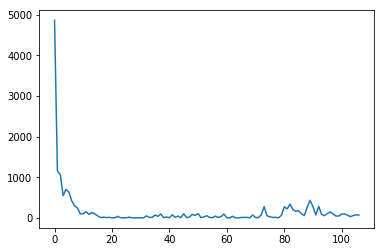

In [12]:
plt.plot(critic_losses)

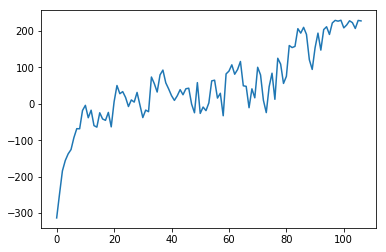

In [13]:
plt.plot(total_rewards)

In [13]:
total_rewards[-20:]

[228.13721106498343,
 219.79234800137957,
 205.14130040271644,
 211.14985314130232,
 229.760122020361,
 231.0319495101604,
 237.91627977675148,
 217.87437889194635,
 239.6884075921374,
 232.2643710273938,
 235.86532536897553,
 220.2616767275249,
 235.89252147645624,
 234.03173250513268,
 225.62986082146708,
 228.8573662383028,
 202.73916779805757,
 235.6644790472826,
 207.0487352314009,
 221.27192021690968]

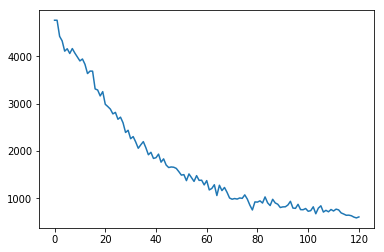

In [21]:
plt.plot(critic_losses)

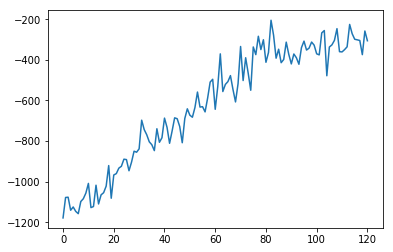

In [22]:
plt.plot(total_rewards)

### Test trained policy

In [40]:
def test_policy(env, policy, num_episodes):
    total_reward = 0
    for ep in range(num_episodes):
        s = env.reset()
        for i in range(500):
            a = np.random.choice(num_actions, p=policy(s))
            s_, r, done, _ = env.step(a)
            total_reward += r
            s = s_
            if done:
                break
    avg_reward = total_reward / num_episodes
    print ("Average reward over {} episodes is {}".format(num_episodes, avg_reward))

In [41]:
test_policy(env, policy, 100)

Average reward over 100 episodes is 126.11


### Visualize trained policy

In [31]:
s = env.reset()
for i in range(500):
    a = np.random.choice(num_actions, p=policy(s))
    s_, r, done, _ = env.step(a)
    s = s_
    env.render()
    if done:
        break
print (i)

108


In [2]:
env = gym.make("MountainCar-v0")
# set some random seed for reproducibility
env.seed(1)

# hyperparameters

state_shape = env.observation_space.shape
num_actions = env.action_space.n

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
s = env.reset()
for i in range(500):
    a = np.random.randint(num_actions)
    s_, r, done, _ = env.step(a)
    s = s_
    env.render()
    if done:
        break
print (i)

199
